In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import typhon

In [6]:
store_path = "/work/mh0066/m301046/beach_lvl3_clearsky_fluxes/"

# Load sonde dataset

In [10]:
# IPFS settings
IPFS_GATEWAY = "https://ipfs.io"
IPFS_HASH = "bafybeicb33v6ohezyhgq5rumq4g7ejnfqxzcpuzd4i2fxnlos5d7ebmi3m"
lvl3 = xr.open_dataset(f"{IPFS_GATEWAY}/ipfs/{IPFS_HASH}", engine="zarr").swap_dims(
    {"sonde": "sonde_id"}
)
ds = xr.open_dataset(store_path + "sonde_profiles.nc").swap_dims({"sonde": "sonde_id"})

In [35]:
lvl3_vmr = xr.apply_ufunc(
    typhon.physics.relative_humidity2vmr,
    lvl3["rh"],
    lvl3["p"],
    lvl3["ta"],
    output_dtypes=[float],
)

In [37]:
lvl3 = lvl3.assign(vmr=lvl3_vmr)

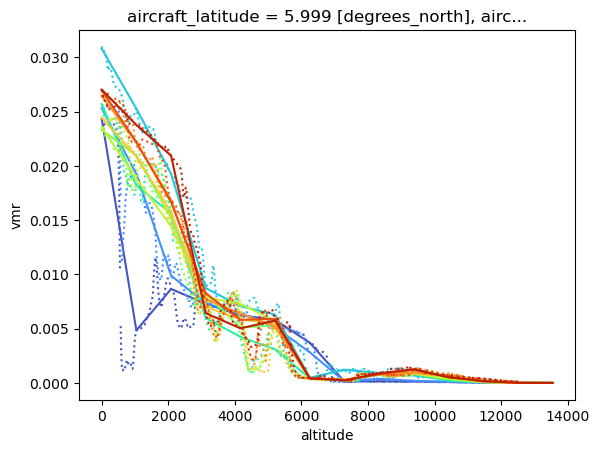

In [41]:
colors = sns.color_palette("turbo", n_colors=10)
for c, sonde_id in zip(colors, ds.sonde_id[:10]):
    ds.sel(sonde_id=sonde_id, altitude=slice(0, 14000)).H2O.plot(color=c)
    lvl3.sel(sonde_id=sonde_id).vmr.plot(linestyle=":", color=c)

# Load Simulated lw fluxes

In [7]:
flux_data_halis = xr.open_dataset(store_path + "flux_data_halis.nc")
flux_data_rrtmgp = xr.open_dataset(store_path + "rrtmgp/flux_data.nc")
# flux_data_arts2 = xr.open_dataset(store_path +"arts2/flux_data.nc")

In [15]:
import xarray as xr

flux_data_arts2 = xr.open_dataset(
    "/work/mh0066/m301046/ml_clouds/arts2_fluxes.zarr", engine="zarr"
)

In [16]:
flux_data_arts2.lw_flux_up.values

array([[433.42197, 432.74414, 430.43378, ..., 297.5445 , 297.5946 ,
        297.63458],
       [448.5954 , 447.13556, 443.87988, ..., 299.12375, 299.17383,
        299.2138 ],
       [460.3807 , 459.1725 , 456.28317, ..., 281.00168, 281.05215,
        281.09247],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)

# Plots
To plot against pressure you will have to load the sonde profile ds that was used for simulation and use its pressure profile

## Flux up vs altitude

(0.0, 12000.0)

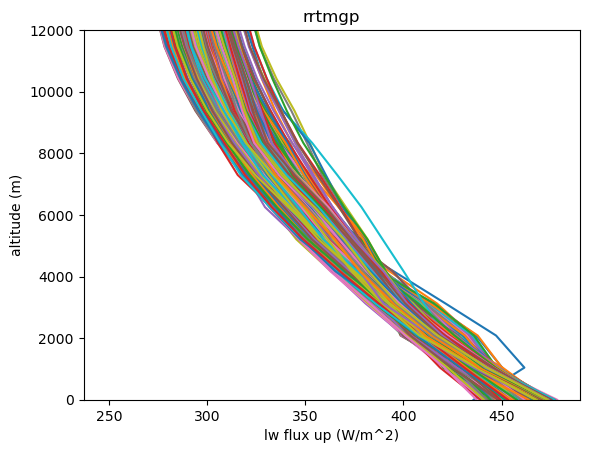

In [8]:
# rrtmgp lw flux up vs altitude
plt.plot(flux_data_rrtmgp.lw_flux_up.T, flux_data_rrtmgp.altitude)
plt.title("rrtmgp")
plt.xlabel("lw flux up (W/m^2)")
plt.ylabel("altitude (m)")
plt.ylim(0, 12000)

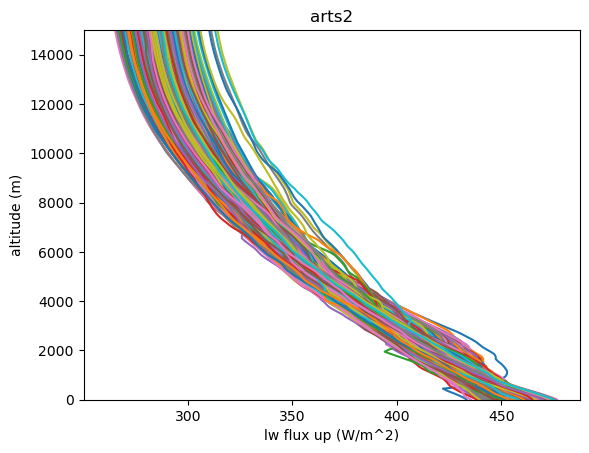

In [19]:
# arts2 lw flux up vs altitude
plt.plot(flux_data_arts2.lw_flux_up.T, flux_data_arts2.altitude)
plt.title("arts2")
plt.xlabel("lw flux up (W/m^2)")
plt.ylabel("altitude (m)")
plt.ylim(0, 15000)
plt.show()

## Flux up Difference arts2 rrtmgp

(-5.0, 0.0)

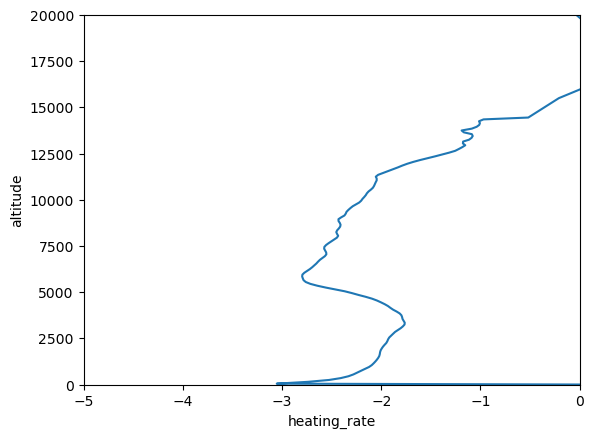

In [25]:
flux_data_arts2.heating_rate.mean("sonde").plot(y="altitude")
plt.ylim(0, 15000)
plt.xlim(-5, 0)

In [26]:
flux_data_arts2.heating_rate.min()

<xarray.DataArray 'heating_rate' ()>
array(-22.413778, dtype=float32)

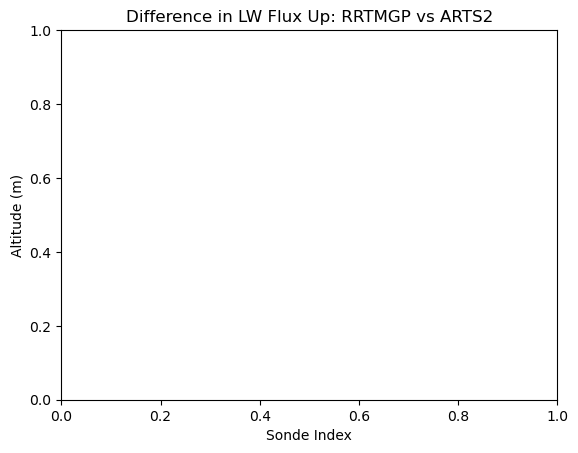

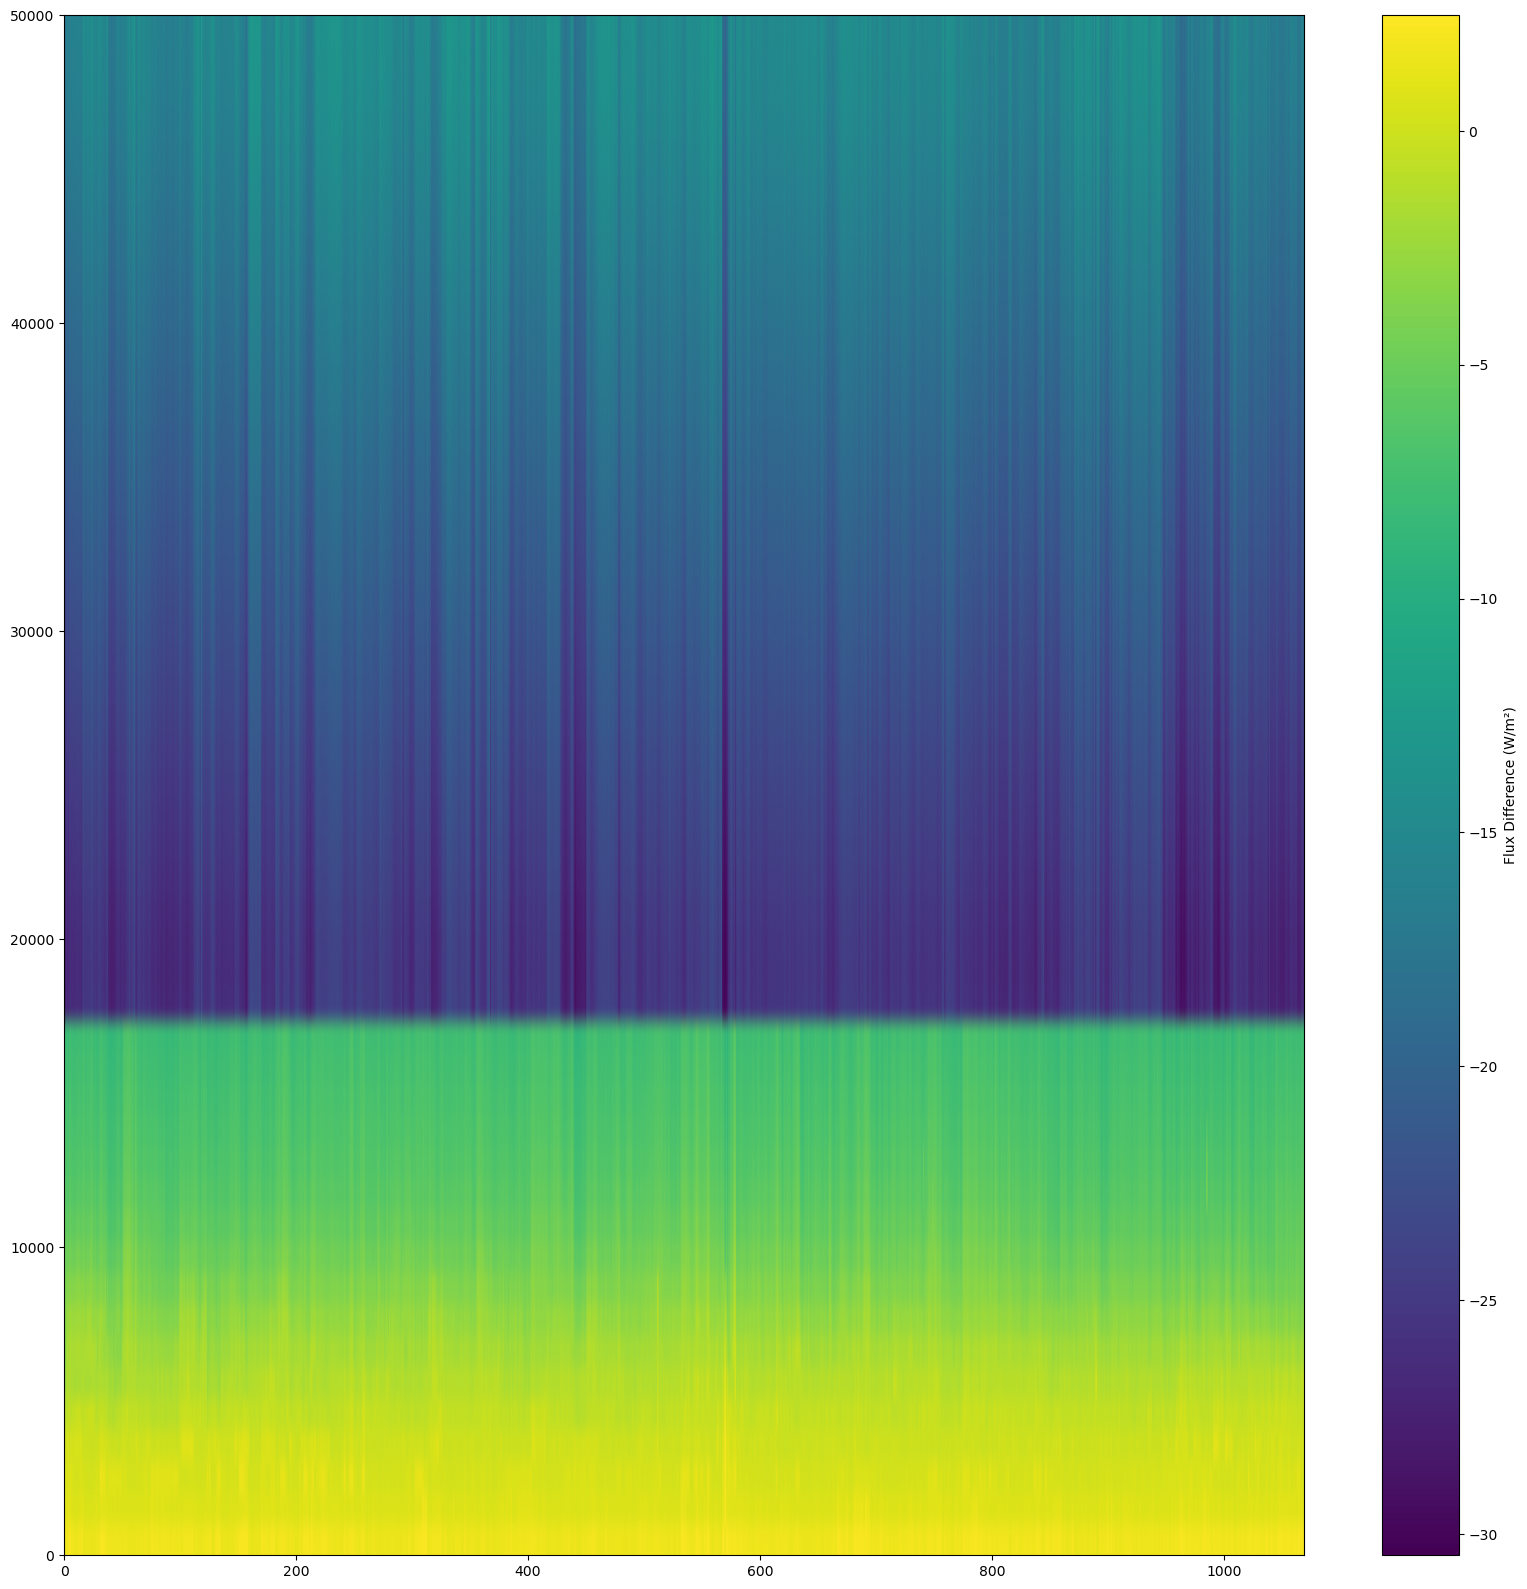

In [33]:
# Vertical profile of the difference in upward longwave flux between RRTMGP and ARTS2 across all sondes.
plt.title("Difference in LW Flux Up: RRTMGP vs ARTS2")
plt.xlabel("Sonde Index")
plt.ylabel("Altitude (m)")

plt.figure(figsize=(20, 20))

num_sondes = flux_data_rrtmgp.sonde.size
altitudes = flux_data_rrtmgp.altitude.values
alt_min, alt_max = altitudes.min(), altitudes.max()

# Plot
img = plt.imshow(
    (flux_data_rrtmgp.lw_flux_up - flux_data_arts2.lw_flux_up).T,
    aspect="auto",
    extent=[0, num_sondes, alt_min, alt_max],
    origin="lower",
)

# Add colorbar with units
cbar = plt.colorbar(img)
cbar.set_label("Flux Difference (W/m²)")

plt.show()

## other

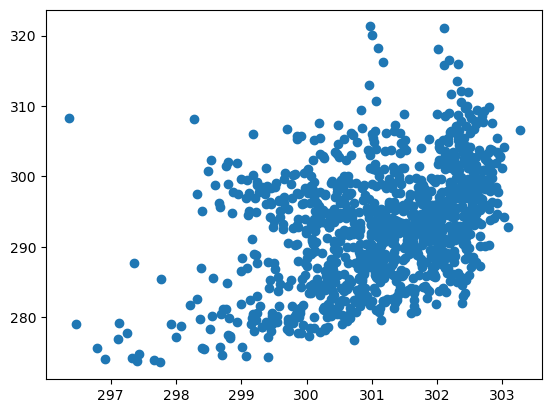

In [14]:
# scatter plot olr vs lowest measured air temp
plt.scatter(
    ds.isel(altitude=0).t.values,
    flux_data_arts2.lw_flux_up.sel(altitude=50000, method="nearest").values.T,
)

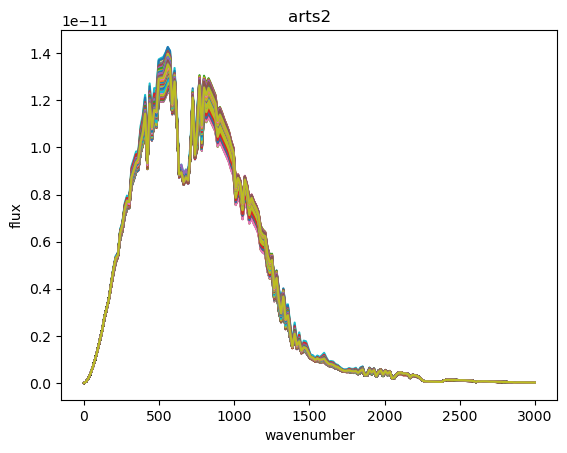

In [80]:
# arts2 spectrally resolved lw flux up vs wavenumber
plt.plot(
    flux_data_arts2.f_grid, flux_data_arts2.lw_flux_up_spectral.mean(dim="altitude").T
)
plt.xlabel("wavenumber")
plt.ylabel("flux")
plt.title("arts2")
plt.show()

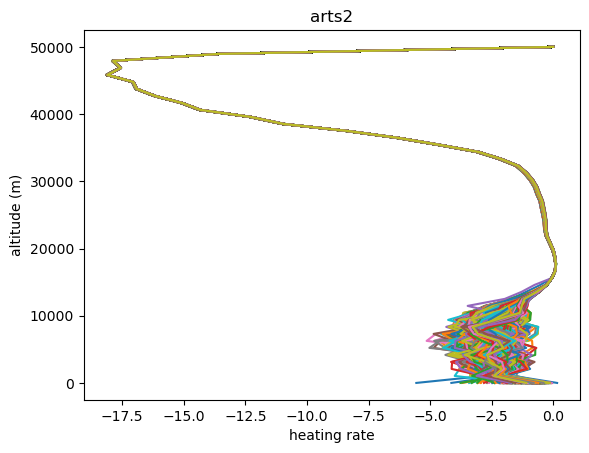

In [34]:
# arts2 heating rate vs altitude
plt.plot(flux_data_arts2.heating_rate.T, flux_data_arts2.altitude)
plt.title("arts2")
plt.xlabel("heating rate")
plt.ylabel("altitude (m)")
plt.show()